
# cGAN Code for SINR Estimation

- **Author:** Matheus Ferreira Silva 
- **Email:** matheus.ferreira@get.inatel.br
- **Date:** September 2024

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Disable TensorFlow warnings

import keras
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from keras import layers, Input, Model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


2024-09-20 10:57:10.081879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 10:57:10.093050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 10:57:10.096312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Utils

In [2]:
def create_prediction_folder():
    """
    Creates a new 'predictX' folder in the 'runs' directory.
    It checks for the highest numbered folder and increments the number for the new folder.

    Returns:
        str: Path to the newly created prediction folder.
    """
    runs_folder = 'runs'
    
    # Create the 'runs' folder if it doesn't exist
    if not os.path.exists(runs_folder):
        os.makedirs(runs_folder)
    
    # Get the current highest 'predictX' folder number
    existing_folders = [f for f in os.listdir(runs_folder) if f.startswith('predict')]
    if existing_folders:
        max_number = max([int(f.replace('predict', '')) for f in existing_folders])
    else:
        max_number = 0
    
    # Create the new 'predictX' folder
    new_folder_name = f'predict{max_number + 1}'
    new_folder_path = os.path.join(runs_folder, new_folder_name)
    os.makedirs(new_folder_path)
    
    return new_folder_path

# Folder to save prediction results
# folder_to_save = create_prediction_folder()

## GPU

In [3]:
# Specify GPU to use (e.g., GPU 0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Available GPU(s): {[gpu.name for gpu in gpus]}")
    print(f"Using GPU: {tf.test.gpu_device_name()}")
else:
    print("No GPU detected. Running on CPU.")

# Display TensorFlow version and CUDA/cuDNN information if available
print(f"TensorFlow version: {tf.__version__}")

if tf.test.is_built_with_cuda():
    build_info = tf.sysconfig.get_build_info()
    print(f"TensorFlow is built with CUDA support")
    print(f"CUDA version: {build_info['cuda_version']}")
    print(f"cuDNN version: {build_info['cudnn_version']}")
else:
    print("Running on CPU (No CUDA support detected).")


Available GPU(s): ['/physical_device:GPU:0']
Using GPU: /device:GPU:0
TensorFlow version: 2.17.0
TensorFlow is built with CUDA support
CUDA version: 12.3
cuDNN version: 8


I0000 00:00:1726840632.680886  765344 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726840632.718795  765344 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726840632.729392  765344 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726840632.741455  765344 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Constants and hyperparameters

In [4]:
num_ports = 144  # Total number of ports (N = 144)

# The observed ports are the context for the GAN, they are not classes, 
# but a context used to provide to the generator an idea of what the generator is going to generate
observed_ports = int(0.2 * num_ports)  # 20% of total ports used as observed ports

latent_dim = 128  # Latent space dimension (random noise)
batch_size = 32  # Batch size for training

height = int(np.sqrt(num_ports))
width = int(np.sqrt(num_ports))
channels = 1 # SINR data has 1 channel (real values)

## Load and Preprocess Data

In [5]:
def generate_sinr_data(num_samples=10000):
    """
    Generates random SINR (Signal to Interference plus Noise Ratio) data for training.

    Args:
        num_samples (int): Number of SINR samples to generate.

    Returns:
        sinr_data (np.array): Generated SINR data of shape (num_samples, height, width).
    """
    # Generate random SINR values following the Rayleigh distribution
    sinr_data = np.random.rayleigh(scale=1, size=(num_samples, height, width, channels))
    return sinr_data


def get_observed_ports(sinr_data, num_samples):
    """ "
    Extracts linearly spaced observed ports from the SINR data.

    Args:
        sinr_data (np.array): Full SINR data of shape (num_samples, height, width, channels).
        num_ports (int): Total number of ports (height * width).
        observed_ports (int): Number of observed ports.

    Returns:
        observed_sinr (np.array): Linearly spaced subset of SINR data of shape (num_samples, observed_height, observed_width, channels).
    """

    # Create a grid of coordinates representing the (height, width) indices
    indices = np.linspace(0, num_ports - 1, observed_ports, dtype=int)  # Get linearly spaced indices
    selected_rows = np.floor(indices // width).astype(int)  # Get row indices
    selected_cols = np.mod(indices, width).astype(int)  # Get column indices

    # Initialize the observed SINR data array
    observed_sinr = np.zeros((num_samples, observed_ports, 1, channels))

    # Gather the observed SINR values from the corresponding linearly spaced ports
    for i in range(observed_ports):
        observed_sinr[:, i, 0, :] = sinr_data[:, selected_rows[i], selected_cols[i], :]

    return observed_sinr


def load_sinr_data(filepath, key="gamma_k"):
    """
    Loads the SINR data from a .mat file and reshapes it.

    Args:
        filepath (str): Path to the .mat file containing SINR data.
        key (str): Key to access the SINR matrix inside the .mat file.

    Returns:
        sinr_data (np.array): Loaded and reshaped SINR data of shape (num_samples, height, width, channels).
    """
    # Load the .mat file
    mat = scipy.io.loadmat(filepath)

    # Extract the SINR matrix
    sinr_matrix = mat[key]

    # Reshape the SINR matrix to match the expected input format
    num_samples = sinr_matrix.shape[0]
    sinr_data = sinr_matrix.reshape(num_samples, height, width, channels)

    return sinr_data

In [6]:
# Load the SINR data from the .mat file
sinr_data = load_sinr_data('data/dataset_SINR_kappa_mu_shadowed/SINR.mat')

# ----------------------- Normalize Using MinMaxScaler ----------------------- #
# Reshape the SINR data to a 2D array for scaling
sinr_data_flat = sinr_data.reshape(-1, 1)

# Initialize MinMaxScaler and scale the SINR data
scaler = MinMaxScaler(feature_range=(0, 1))
sinr_data_scaled = scaler.fit_transform(sinr_data_flat)

# Reshape back to the original shape
sinr_data = sinr_data_scaled.reshape(sinr_data.shape[0], height, width, channels)

# Cast sinr_data to float32
sinr_data = sinr_data.astype(np.float32)
# ------------------------------------- - ------------------------------------ #

# Generate observed SINR data
observed_sinr = get_observed_ports(sinr_data, num_samples=sinr_data.shape[0])

# Cast observed_sinr to float32
observed_sinr = observed_sinr.astype(np.float32)

# Print the shape of the SINR data
print("SINR data shape:", sinr_data.shape)
print("Observed SINR data shape:", observed_sinr.shape)

# Create a TensorFlow dataset from the SINR data
dataset = tf.data.Dataset.from_tensor_slices((sinr_data, observed_sinr)).batch(batch_size)

SINR data shape: (40000, 12, 12, 1)
Observed SINR data shape: (40000, 28, 1, 1)


I0000 00:00:1726840633.270071  765344 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726840633.272330  765344 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726840633.274086  765344 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726840633.275930  765344 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## cGAN Model training

#### Generator

In [7]:
def build_generator(latent_dim, observed_ports):
    """
    Builds the generator model for the Conditional GAN (cGAN).
    The generator takes random noise and observed SINR values as input and generates fake SINR maps.
    
    Args:
        latent_dim (int): Dimension of the latent space (random noise).
        observed_ports (int): Number of observed ports (features).
        
    Returns:
        model (tf.keras.Model): The compiled generator model.
    """
    
    # ------------------------------- Input layer ------------------------------- #
    """
    The input noise for the generator z is sampled from the Gaussian distribution with
    zero mean and unit variance with the dimension of 128. Thus, the input Y of the generator 
    is Y = z + L
    
    The latent_dim is the dimension of z (random noise).
    L is the labels (observed SINR values).
    """
    
    inputs = Input(shape=(latent_dim + observed_ports,))
    # Input layer receives a vector of random noise concatenated with observed SINR values.
    # Input shape: (batch_size, latent_dim + observed_ports)

    # --------------- First Dense layer with Reshape for feature generation --------------- #
    x = layers.Dense(27)(inputs)
    x = layers.LeakyReLU(0.2)(x)
    # Apply LeakyReLU activation to introduce non-linearity.
    # Output shape: (None, 27)

    x = layers.Reshape((3, 3, -1))(x)
    # Reshape the output into a feature map

    # ----------------- Convolutional Transpose Layers for Upsampling ---------------- #
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
    # Upsample the feature map to double its spatial dimensions.

    x = layers.LeakyReLU(0.2)(x)
    # Apply LeakyReLU to the upsampled feature map.
    
    # Conv2DTranspose of (12, 12, 128), 2 / Same
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
    # Upsample the feature map to quadruple its spatial dimensions.

    x = layers.LeakyReLU(0.2)(x)
    # Apply LeakyReLU to the upsampled feature map.

    # -------------------------------- Output layer --------------------------------- #
    # Original:
    outputs = layers.Conv2D(channels, (3, 3), padding="same", activation="sigmoid")(x)
    
    # Linear:
    # outputs = layers.Conv2D(channels, (3, 3), padding="same", activation="linear")(x)
    
    # Tanh:
    # outputs = layers.Conv2D(channels, (3, 3), padding="same", activation="tanh")(x)

    # # Compute the max value from the dataset
    # upper_bound = tf.reduce_max(sinr_data)
    # # Multiply by the max value to map the output to the original range
    # outputs = outputs * upper_bound

    # Output shape: (batch_size, height, width, channels)
    return Model(inputs=inputs, outputs=outputs)

# Build the generator
generator = build_generator(latent_dim, observed_ports)
generator.summary()

# Plot and save the generator model architecture
# plot_model(generator, to_file=os.path.join(folder_to_save, 'generator_model.png'), show_shapes=True, show_layer_names=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 156)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 27)             │         4,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 3, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 6, 6, 128)      │         6,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 12, 12, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 12, 12, 1)      │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,936 (1.04 MB)

 Trainable params: 273,936 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

#### Discriminator

In [8]:
def build_discriminator():
    """
    Builds the discriminator model for the Conditional GAN (cGAN).
    The discriminator distinguishes between real and generated SINR maps.

    Returns:
        model (tf.keras.Model): The compiled discriminator model.
    """

    # ------------------------------- Input layer ------------------------------- #
    inputs = Input(shape=(height, width, channels))
    # Input layer expects a SINR map of size (height, width, channels).

    # --------------- First Convolutional Block ---------------- #
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(inputs)
    # First convolutional layer reduces the spatial dimensions.

    x = layers.LeakyReLU(0.2)(x)
    # Apply LeakyReLU to introduce non-linearity.

    # --------------- Second Convolutional Block ---------------- #
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    # Second convolutional layer further reduces spatial dimensions.

    x = layers.LeakyReLU(0.2)(x)
    # Apply LeakyReLU.

    # ----------------------- Global Pooling and Output Layer ---------------------- #
    x = layers.GlobalMaxPooling2D()(x)
    # Global Max Pooling reduces the feature map to a single feature vector per sample.

    outputs = layers.Dense(1)(x)
    # Dense layer outputs a single value representing real or fake prediction.
    # Output shape: (batch_size, 1)

    return Model(inputs=inputs, outputs=outputs)
    
# Build the discriminator
discriminator = build_discriminator()
discriminator.summary()

# Plot and save the discriminator model architecture
# plot_model(discriminator, to_file=os.path.join(folder_to_save, 'discriminator_model.png'), show_shapes=True, show_layer_names=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12, 12, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,625 (291.50 KB)

 Trainable params: 74,625 (291.50 KB)

 Non-trainable params: 0 (0.00 B)

#### cGAN Model

In [9]:
class ConditionalGAN(keras.Model):
    """
    Defines the Conditional GAN (cGAN) model that combines the generator and discriminator.

    The model trains the generator to produce SINR maps that fool the discriminator,
    while training the discriminator to correctly distinguish between real and generated SINR maps.
    """

    def __init__(self, generator, discriminator, latent_dim, mse_punishment=3):
        """
        Initializes the Conditional GAN model with generator and discriminator.

        Args:
            generator (tf.keras.Model): The generator model.
            discriminator (tf.keras.Model): The discriminator model.
            latent_dim (int): The dimension of the latent space.
            mse_punishment (float): Weighting factor for the generator loss.
        """
        super(ConditionalGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.mse_tracker = keras.metrics.Mean(name="mse_loss")
        self.mse_punishment = mse_punishment

    @property
    def metrics(self):
        """Returns the tracked metrics for the generator, discriminator, and MSE."""
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.mse_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        """
        Compiles the Conditional GAN model with optimizers and loss function.

        Args:
            d_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the discriminator.
            g_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the generator.
            loss_fn (callable): Loss function to optimize.
        """
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

        # The loss here is a Binary Cross-Entropy loss
        self.loss_fn = loss_fn
        self.mse_fn = keras.losses.MeanSquaredError()

    def train_step(self, data):
        """
        Defines a single training step for the Conditional GAN.

        Args:
            data (tuple): A tuple containing real SINR data and observed SINR data.

        Returns:
            dict: A dictionary of the generator, discriminator, and MSE losses.
        """
        # Unpack the data: real SINR data and observed SINR ports (context/labels)
        # (None, 12, 12, 1) - Input real images
        # (None, 28, 1, 1) - Input observed ports
        real_images, observed_ports = data

        # Generate random noise for the generator
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )  # (None, 128) - Random noise

        # Flatten observed_sinr to a 2D vector for concatenation with random noise
        observed_ports = tf.reshape(observed_ports, [batch_size, -1])  # (None, 28) - Flattened ports

        # Concatenate the random noise with the observed ports
        generator_input = tf.concat(
            [random_latent_vectors, observed_ports], axis=1
        )  # (None, 156) - Latent + ports

        # Generate fake SINR maps
        generated_images = self.generator(generator_input)  # (None, 12, 12, 1) - Fake generated images

        # Combine real and fake images for the discriminator
        combined_images = tf.concat(
            [generated_images, real_images], axis=0
        )  # (None*2, 12, 12, 1) - Real + fake

        # Create labels for real (1) and fake (0) images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )  # (None*2, 1) - Labels

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)  # (None*2, 1) - Discriminator predictions
            d_loss = self.loss_fn(labels, predictions)
        
        # Calculate the gradients of the discriminator loss with respect to the discriminator's weights
        # This computes how much each weight contributes to the loss, which is needed for backpropagation.
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        
        # Apply the computed gradients to the discriminator's weights, updating them to minimize the loss
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate new random latent vectors
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )  # (None, 128) - New latent vectors

        # Concatenate random noise with observed ports for the generator
        generator_input = tf.concat(
            [random_latent_vectors, observed_ports], axis=1
        )  # (None, 156) - Input for generator

        # Labels for the generator training (all ones, as we want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))  # (None, 1) - Fake labels (all ones)

        # Train the generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(
                generator_input
            )  # (None, 12, 12, 1) - Fake images from generator
            predictions = self.discriminator(
                generated_images
            )  # (None, 1) - Discriminator predictions on fake images
            g_loss = self.loss_fn(misleading_labels, predictions)
            mse_loss = self.mse_fn(real_images, generated_images)

            # Punish the generator with MSE loss
            g_loss = g_loss + mse_loss * self.mse_punishment
            
        # Calculate the gradients of the generator loss with respect to the generator's weights
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        
        # Apply them to the generator's weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Return the tracked losses
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.mse_tracker.update_state(mse_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "mse": self.mse_tracker.result(),
        }

In [10]:
class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.g_loss_history = []
        self.d_loss_history = []
        self.mse_history = []

    def on_epoch_end(self, epoch, logs=None):
        self.g_loss_history.append(logs.get('g_loss'))
        self.d_loss_history.append(logs.get('d_loss'))
        self.mse_history.append(logs.get('mse'))

#### Training

In [11]:
# Instantiate and compile the models
cgan = ConditionalGAN(generator, discriminator, latent_dim)


cgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
)

# Instantiate the loss history callback
loss_history = LossHistory()

# Train the cGAN model
cgan.fit(dataset, epochs=10, callbacks=[loss_history])

Epoch 1/10


I0000 00:00:1726840635.112508  767221 service.cc:146] XLA service 0x700e9800e840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726840635.112539  767221 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6


  69/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - d_loss: 0.6306 - g_loss: 0.9815 - mse: 0.1344

I0000 00:00:1726840637.667903  767221 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - d_loss: 0.1571 - g_loss: 0.2236 - mse: 0.0323
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - d_loss: 0.0012 - g_loss: 0.0070 - mse: 0.0020
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 5.4335e-04 - g_loss: 0.0037 - mse: 0.0011
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 2.8581e-04 - g_loss: 0.0023 - mse: 7.0465e-04
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - d_loss: 1.4411e-04 - g_loss: 0.0016 - mse: 4.8685e-04
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - d_loss: 7.1949e-05 - g_loss: 0.0011 - mse: 3.4826e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 4.2329e-05 - g_loss: 8.6275e-04 - mse: 2.7316e-04
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - d_loss: 2.6417e-05 - g_loss: 7.0382e-04 - mse: 2.2576e-04
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - d_loss: 1.6363e-05 - g_loss: 5.9937e-04 - mse: 1.9440e-04
Epoch 10/10
1250/1250 ━━━━━━━

#### Histogram Comparison and Plots

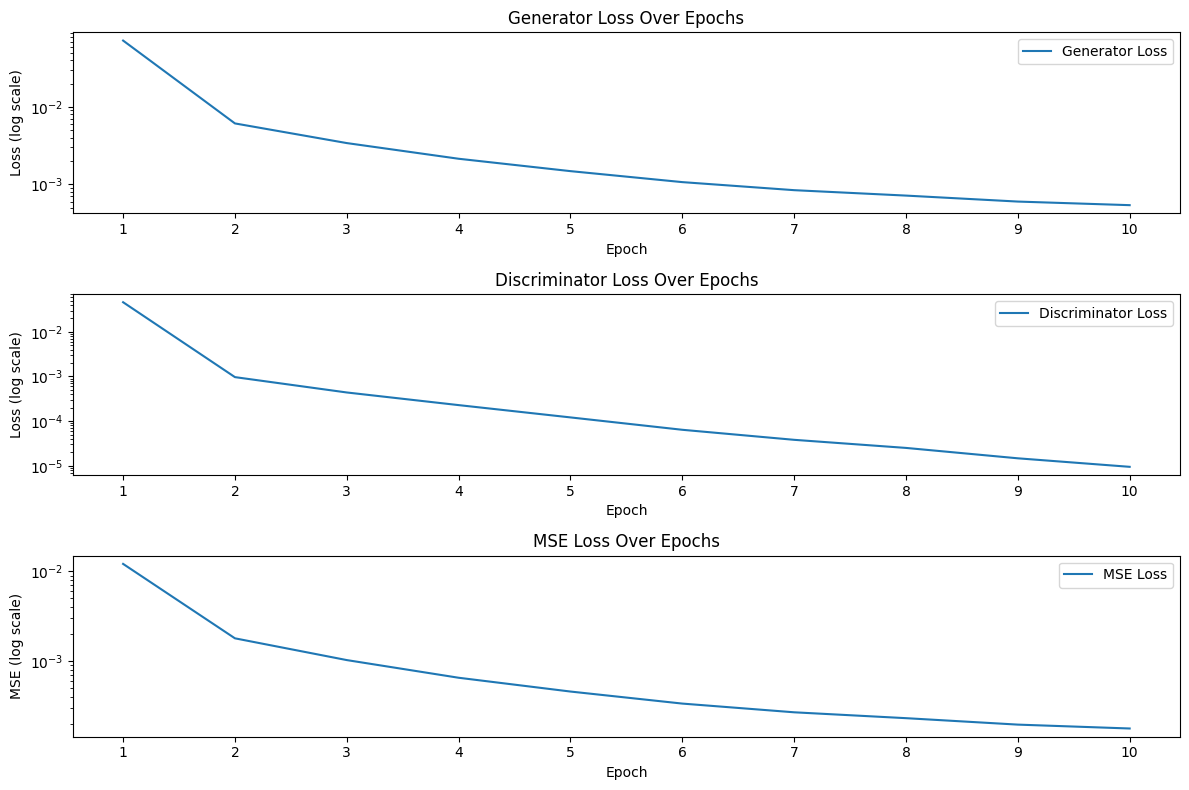

Real SINR shape: (5760000,)


W0000 00:00:1726840662.979842  765344 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726840662.993239  765344 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726840662.993860  765344 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726840662.994484  765344 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726840662.995089  765344 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726840662.995681  765344 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726840662.996467  765344 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726840662.997307  765344 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726840662.998110  765344 gp

Generated SINR shape: (5760000,)


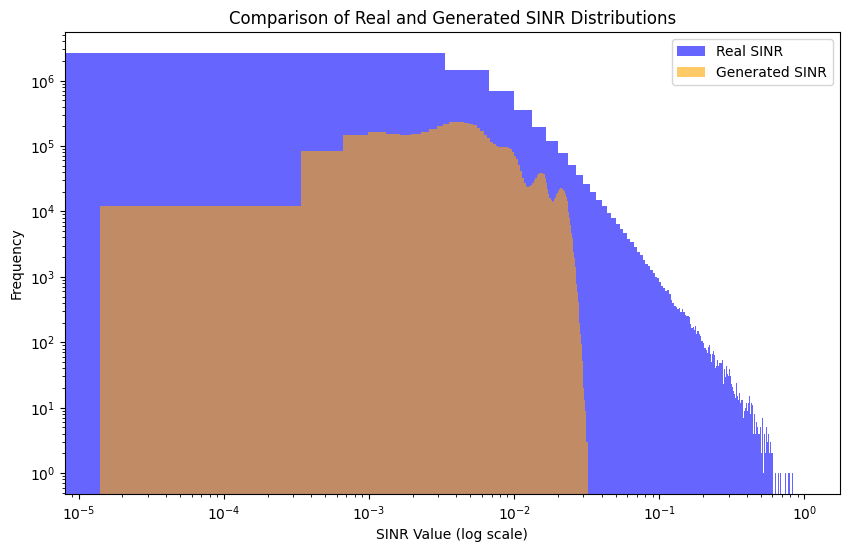

In [12]:
def plot_losses(g_loss_history, d_loss_history, mse_history):
    """
    Plots the generator loss, discriminator loss, and MSE loss over epochs.

    Args:
        g_loss_history (list): Generator loss history.
        d_loss_history (list): Discriminator loss history.
        mse_history (list): MSE loss history.
    """
    epochs = range(1, len(g_loss_history) + 1)  # Epoch numbers (1, 2, ..., N)

    plt.figure(figsize=(12, 8))

    # Plot generator loss (logarithmic scale)
    plt.subplot(3, 1, 1)
    plt.plot(epochs, g_loss_history, label="Generator Loss")
    plt.yscale('log')  # Logarithmic scale for y-axis
    plt.xticks(np.linspace(1, len(epochs), num=10, dtype=int))  # Ensure x-axis is integers only
    plt.title("Generator Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log scale)")
    plt.legend()

    # Plot discriminator loss (logarithmic scale)
    plt.subplot(3, 1, 2)
    plt.plot(epochs, d_loss_history, label="Discriminator Loss")
    plt.yscale('log')  # Logarithmic scale for y-axis
    plt.xticks(np.linspace(1, len(epochs), num=10, dtype=int))  # Ensure x-axis is integers only
    plt.title("Discriminator Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log scale)")
    plt.legend()

    # Plot MSE loss (logarithmic scale)
    plt.subplot(3, 1, 3)
    plt.plot(epochs, mse_history, label="MSE Loss")
    plt.yscale('log')  # Logarithmic scale for y-axis
    plt.xticks(np.linspace(1, len(epochs), num=10, dtype=int))  # Ensure x-axis is integers only
    plt.title("MSE Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE (log scale)")
    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Function to generate and plot the histograms with batch processing
def plot_sinr_histograms(real_data, generated_data, title="SINR Distribution Comparison"):
    """
    Plots histograms of real and generated SINR data.

    Args:
        real_data (np.array): Real SINR data (flattened).
        generated_data (np.array): Generated SINR data (flattened).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot histograms with a log-scaled x-axis
    plt.hist(real_data, bins=300, alpha=0.6, color="blue", label="Real SINR", log=True)
    plt.hist(generated_data, bins=100, alpha=0.6, color="orange", label="Generated SINR", log=True)
    
    plt.xscale('log')  # Logarithmic x-axis for better visualization of skewed data
    plt.title(title)
    plt.xlabel("SINR Value (log scale)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Generate fake SINR maps in batches to avoid memory overload
def generate_fake_sinr_in_batches(generator, observed_sinr, latent_dim, batch_size=1000):
    """
    Generates fake SINR maps using the generator model in smaller batches.

    Args:
        generator (tf.keras.Model): The generator model.
        observed_sinr (np.array): Observed SINR data (for conditioning).
        latent_dim (int): Latent dimension for random noise.
        batch_size (int): The size of each batch for generation.

    Returns:
        generated_sinr (np.array): Generated SINR data (flattened).
    """
    num_samples = observed_sinr.shape[0]
    generated_sinr_flat = []

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)

        # Slice the observed SINR data for the current batch
        observed_sinr_batch = observed_sinr[start_idx:end_idx]

        # Random latent vectors for the batch
        random_latent_vectors = tf.random.normal(shape=(observed_sinr_batch.shape[0], latent_dim))

        # Flatten observed_sinr to concatenate with random noise
        observed_sinr_flat_batch = observed_sinr_batch.reshape(observed_sinr_batch.shape[0], -1)

        # Concatenate random noise with observed SINR values
        generator_input = tf.concat([random_latent_vectors, observed_sinr_flat_batch], axis=1)

        # Generate fake SINR maps for the current batch
        generated_sinr_batch = generator(generator_input).numpy().flatten()

        # Append to the list of generated SINR
        generated_sinr_flat.append(generated_sinr_batch)

    # Concatenate all the generated SINR batches
    return np.concatenate(generated_sinr_flat)


# Plot the losses after training
plot_losses(loss_history.g_loss_history, loss_history.d_loss_history, loss_history.mse_history)

# Flatten the real SINR data for histogram comparison
real_sinr_flat = sinr_data.flatten()
print(f"Real SINR shape: {real_sinr_flat.shape}")

# Generate fake SINR maps in batches and flatten them
generated_sinr_flat = generate_fake_sinr_in_batches(generator, observed_sinr, latent_dim)
print(f"Generated SINR shape: {generated_sinr_flat.shape}")

# Plot the histograms
plot_sinr_histograms(
    real_sinr_flat, generated_sinr_flat, title="Comparison of Real and Generated SINR Distributions"
)

In [16]:
# Number of samples to generate
num_samples = 5

# Select a batch of observed SINR for the generator
observed_sinr_batch = observed_sinr[:num_samples]

# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))

# Flatten observed SINR for concatenation
observed_sinr_flat = observed_sinr_batch.reshape(num_samples, -1)

# Concatenate the random latent vectors with observed SINR
generator_input = tf.concat([random_latent_vectors, observed_sinr_flat], axis=1)

# Generate fake SINR maps
generated_samples = generator(generator_input)

# Reshape the generated samples to (num_samples, num_ports)
num_ports = height * width  # Calculate the total number of ports
concatenated_samples = generated_samples.numpy().reshape(num_samples, num_ports)

# Get the real SINR data and reshape it to match (num_samples, num_ports)
real_sinr = sinr_data[:num_samples].reshape(num_samples, num_ports)

# Print the generated samples
print(f"Generated SINR samples shape: {concatenated_samples.shape}")
print(f"Generated SINR samples [0]: \n{concatenated_samples[0]}")

# Print the real samples
print(f"Real SINR samples shape: {real_sinr.shape}")
print(f"Real SINR samples [0]: \n{real_sinr[0]}")


Generated SINR samples shape: (5, 144)
Generated SINR samples [0]: 
[0.00804057 0.00502846 0.01149961 0.0055954  0.00898959 0.00293065
 0.01026832 0.00524311 0.00945186 0.00460362 0.00675068 0.00771415
 0.00560884 0.00417873 0.00498169 0.00541182 0.00443971 0.00345044
 0.00660878 0.00698609 0.0058109  0.00667617 0.00391282 0.00708543
 0.01115896 0.00293277 0.01712263 0.00226865 0.01574938 0.00098066
 0.01520788 0.00294018 0.0138322  0.00096645 0.01069359 0.00388759
 0.00570376 0.00526343 0.00478181 0.00504181 0.00350511 0.00260949
 0.00440737 0.00596179 0.00454017 0.00438258 0.00349749 0.00484905
 0.0078638  0.00239994 0.01381323 0.00114954 0.0202981  0.0009031
 0.02094889 0.00191407 0.01728191 0.00035268 0.01477327 0.00328621
 0.00440611 0.00324509 0.00298326 0.00234417 0.00228044 0.00255218
 0.00243935 0.00412321 0.0008052  0.00068521 0.00152998 0.00377156
 0.01056015 0.00344892 0.01435544 0.00275023 0.02353197 0.00094891
 0.02636835 0.00244085 0.02263536 0.00085554 0.01754021 0.0043